This notebook executes L2HMC  to solve for Hexagonal Lattice Hubbard model

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from tqdm.notebook import tqdm
import itertools
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
device = 'cpu'

In [3]:
torchType = torch.float32
numpyType = np.float32

In [4]:
def calcExpK(delta):
    """Function that calculates exponential of hopping matrix"""
    return [[np.cosh(delta),np.sinh(delta)],[np.sinh(delta),np.cosh(delta)]]


In [5]:
def Mphi(phi, expk, nt):
    """
    Function that updates the Fermion matrix using exponential discretization
    INPUT:
            phi - phi field (array)
            k - hopping parameter (array)
            nt - number of time steps
                        
    OUTPUT:
            M - fermion matrix (update M) 
            
            This uses space index fastest (like Isle)
    """
    n = len(phi)
    nx = int(n/nt)
    if n == M.shape[0]: # this tests if the phi array has the right dimensions
        for t in range(nt-1): # loop over time bloks
            for x in range(nx): # loop over cords and kappa matrix
                M[t*nx+x][t*nx+x] = 1.0 + 0j # diagonal term
                for y in range(nx): # run over the kappa matrix
                    M[(t+1)*nx+x][t*nx+y] = -expk[x][y]*np.exp(1j*phi[t*nx+y]) # off-diagonal
        for x in range(nx): 
            M[(nt-1)*nx+x][(nt-1)*nx+x] = 1.0+0j # diagonal term
            for y in range(nx): # anti-periodic boundary condition
                M[x][(nt-1)*nx+y] = expk[x][y]*np.exp(1j*phi[(nt-1)*nx+y])
        return 0
    else:
        print('# Error! phi and M have inconsistent dimensions!')
        return -1

In [6]:
# %store actual_HMC
#data from running state of the art HMC 
# actual_HMC = np.load("actualHMCU2B4Nt16.npy")
# HMCNotebook = np.array(actual_HMC)
# print("HMCNotebook shape=",HMCNotebook.shape)

## initialize constants for the HH

In [7]:
U=4.                     # spin coupling
beta=6.                  # inverse temperature
Nt=32            # number of time steps
Nx = 2                   # number of sites
delta = beta/Nt          # time discretization
deltaU = delta*U           #reduced U
usqrt = np.sqrt(deltaU)
expk = calcExpK(delta)   # exp(kappa)
x_dim = Nt*Nx
print(f"U = {U}, beta = {beta}, Nt = {Nt}, Nx = {Nx}, Usqrt = {usqrt}, x_dim = {x_dim}")

U = 4.0, beta = 6.0, Nt = 32, Nx = 2, Usqrt = 0.8660254037844386, x_dim = 64


## L2HMC executing the state of the art HMC when the NN is turned off

In [8]:
def get_hmc_samples(x_dim, eps, T=10, steps=10, samples=None):
    hmc_dynamics = Dynamics(x_dim,deltaU,expk,Nt,T, eps,n_samples, hmc=True)
    if samples is None:
        samples = torch.normal(0.0,usqrt,size=(n_samples,x_dim))
#         samples = torch.tensor(HMCNotebook[:n_samples], dtype=torch.float32)

    final_samples = []
    samples_accepted = []
    HMC_px = []
    with torch.no_grad():
        for _ in tqdm(range(steps)): 
            _, _, prob, samples = propose(samples,n_samples, hmc_dynamics, do_mh_step=True) # new coordinates, new momenta, new acceptance probability,[accepted coordinate,mask]
            HMC_px.append(prob.detach().numpy())
            samples_accepted.append(samples[0][1].detach().numpy())
            samples = samples[0][0]
            final_samples.append(samples.detach().numpy())  
  
    return np.array(final_samples),np.array(HMC_px),np.array(samples_accepted)

In [9]:
#configuartions using  L2HMC without NN
from dynamics import Dynamics
from samplerModified import propose

eps = 0.2
Nmd = 5
n_samples = 1
nTrajs = 10000
with torch.no_grad():
    HMC_samples,HMC_prob,HMC_accepted = get_hmc_samples(x_dim,eps,T=Nmd,steps=nTrajs)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
HMC_samples_reduced = HMC_samples.reshape(nTrajs,x_dim)
print("HMC samples shape =",HMC_samples.shape)
print("HMC mean px=",np.mean(HMC_prob))
print("HMC acceptance prob=",sum(HMC_accepted)/len(HMC_accepted))
print("HMC samples reshaped=",HMC_samples_reduced.shape)

HMC samples shape = (10000, 1, 64)
HMC mean px= 0.81058574
HMC acceptance prob= 0.81
HMC samples reshaped= (10000, 64)


# Network architecture



We define the network architecture for our L2HMC network. We first embed the first two variables ($\{x, \partial_x U\}$ or $\{v, x_m\}$) as well as the time, formatted as $\tau(t) = \left(\cos(\frac{2\pi t}{M}), \sin(\frac{2\pi t}{M})\right)$. They are forwarded through an MLP and then produce $S, T$ and $Q$.

# Training L2HMC

In [ ]:
from dynamics import Dynamics
from layers import Net
from samplerModified import propose

print(f"U = {U}, beta = {beta}, Nt = {Nt}, Nx = {Nx}, Usqrt = {usqrt}, x_dim = {x_dim}")
eps = 0.01
Nmd = 5
loss_plot = []
epochs = 400
training_samples = 200
scale_trainable = True
scale_const = torch.tensor(0.2) 
scale = torch.tensor(0.1)
# scale = nn.Parameter(torch.tensor(scale_const,dtype=torchType),requires_grad=scale_trainable)
dynamics = Dynamics(x_dim,deltaU,expk,Nt,T=Nmd, eps=eps,net_factory=Net,eps_trainable=True, use_temperature=False)
optim = Adam(dynamics.parameters())
# optim = Adam(itertools.chain(dynamics.parameters(), (scale,)))
scheduler = StepLR(optim, step_size=100, gamma=0.96)

def criterion(v1,v2): #loss function lamda_{b} = 1 : stuck penalty + large moves
    return scale * (torch.mean(1.0 / v1) + torch.mean(1.0 / v2) )  + (-torch.mean(v1)-torch.mean(v2)) / scale

t = 0
# for t in tqdm(range(epochs)):
with tqdm(total=epochs) as pbar:
    while t < epochs:
        if(t==0):
             x = torch.normal(0.0,usqrt,size=(training_samples,x_dim))
#             x = torch.from_numpy(HMC_samples_reduced[:training_samples])
#             x = x.type(torch.float32)
    #         v = torch.normal(0.0,1.0,size=(n_samples,x_dim))
        else:
            x = output[0].data
    #         v = Lv.data
        
#         random_index = torch.randint(0,len(HMC_samples_reduced),size=(training_samples,1))
#         z = torch.from_numpy(HMC_samples_reduced[random_index].reshape(training_samples,x_dim))
        z = torch.normal(0.0,usqrt,size=(training_samples,x_dim))

        optim.zero_grad()
        Lx, Lv, px, output,log_jac,directions = propose(x,training_samples, dynamics, do_mh_step=True, temperature=None)
        Lz, _, pz, _,_,_ = propose(z,training_samples, dynamics, do_mh_step=False)

        v1 = (torch.sum((x - Lx)**2, dim=1) * px) + torch.tensor(1e-4)   #loss on target distribution: burn in regularization
        v2 = (torch.sum((z - Lz)**2, dim=1) * pz) + torch.tensor(1e-4)   # loss on initial distribution: fast mixing
        loss = criterion(v1,v2) 
        loss_plot.append(loss)


        loss.backward()
        optim.step()  
        mean_px = np.mean(px.detach().numpy())

        if (t % 10 == 0) or (t == epochs-1):
            current_lr = None
            pbar.update(10)
            for param_group in optim.param_groups:
                current_lr = param_group['lr']
                current_eps = np.exp(param_group['params'][0].detach().numpy())
            print ('Step: %d / %d, Loss: %.2e,Acceptance sample prob: %.2f,scale: %.4f,eps: %.4f, LR: %.5f' % (t, epochs, loss.item(),mean_px,scale,current_eps, current_lr))
        if t == epochs-1 and  mean_px < 0.60:
#             np.abs(loss_plot[-1].detach().numpy()) > 1.0 and
            epochs = epochs + 1
            pbar.update(1)

        t = t + 1  
#         scheduler.step()
       





U = 4.0, beta = 6.0, Nt = 32, Nx = 2, Usqrt = 0.8660254037844386, x_dim = 64


  0%|          | 0/400 [00:00<?, ?it/s]

Step: 0 / 400, Loss: -4.95e+00,Acceptance sample prob: 0.67,scale: 0.1000,eps: 0.0100, LR: 0.00100
Step: 10 / 400, Loss: -7.93e+00,Acceptance sample prob: 0.45,scale: 0.1000,eps: 0.0101, LR: 0.00100
Step: 20 / 400, Loss: -9.09e+00,Acceptance sample prob: 0.26,scale: 0.1000,eps: 0.0101, LR: 0.00100
Step: 30 / 400, Loss: -1.56e+01,Acceptance sample prob: 0.36,scale: 0.1000,eps: 0.0101, LR: 0.00100
Step: 40 / 400, Loss: -8.05e+00,Acceptance sample prob: 0.28,scale: 0.1000,eps: 0.0100, LR: 0.00100
Step: 50 / 400, Loss: -1.17e+01,Acceptance sample prob: 0.25,scale: 0.1000,eps: 0.0100, LR: 0.00100
Step: 60 / 400, Loss: -8.22e+00,Acceptance sample prob: 0.37,scale: 0.1000,eps: 0.0099, LR: 0.00100
Step: 70 / 400, Loss: 4.14e+02,Acceptance sample prob: 0.36,scale: 0.1000,eps: 0.0099, LR: 0.00100
Step: 80 / 400, Loss: -1.15e+01,Acceptance sample prob: 0.40,scale: 0.1000,eps: 0.0099, LR: 0.00100
Step: 90 / 400, Loss: -1.05e+01,Acceptance sample prob: 0.37,scale: 0.1000,eps: 0.0098, LR: 0.00100
St

In [ ]:
# from numba import jit
# model_l2hmc = dynamics
# torch.jit.script(model_l2hmc)
# script_module.save(f"L2HMC_2sitesU{U}B{beta}Nt{Nt}_{count}.pt")

In [ ]:
# model_check = torch.jit.load(f"L2HMC_2sitesU{U}B{beta}Nt{Nt}_{count}.pt")
# for name,param in model_check.named_parameter():
#     print(name,param)

In [107]:
count = 1 #figure count 

##  Trained parameters of the network

In [72]:
trained_params = {}
for name,param in dynamics.named_parameters():
    trained_params[name] = {param.detach()}
alpha = trained_params['alpha']
final_eps = np.exp(list(alpha))
# print(final_eps,alpha)
print(trained_params)
# np.save(f"trained_paramsU{U}B{beta}Nt{Nt}_{count}.npy",trained_params)

{'alpha': {tensor(-4.6052)}, 'XNet.scale_1': {tensor([[-0.0716, -0.0961, -0.0729, -0.0934, -0.0894, -0.0420, -0.0646, -0.0983,
         -0.0431, -0.0823, -0.0701, -0.0974, -0.0641, -0.0976, -0.1170, -0.0389,
         -0.0651, -0.0725, -0.1082, -0.1090, -0.1025, -0.0596, -0.0577, -0.1213,
         -0.0786, -0.0708, -0.0599, -0.0645, -0.0881, -0.1049, -0.0635, -0.0976,
         -0.0820, -0.0980, -0.0731, -0.0940, -0.0822, -0.0525, -0.1166, -0.0981,
         -0.0541, -0.0834, -0.0921, -0.0959, -0.0835, -0.0741, -0.0679, -0.1008,
         -0.0528, -0.0805, -0.1132, -0.0744, -0.0487, -0.0696, -0.0855, -0.0984,
         -0.0758, -0.0381, -0.0536, -0.1058, -0.0814, -0.0756, -0.0433, -0.0446]])}, 'XNet.scale_3': {tensor([[ 0.1829,  0.2179,  0.2101,  0.1905,  0.1826,  0.2013,  0.1587,  0.1924,
          0.1826,  0.1511,  0.1062,  0.1629,  0.2036,  0.1638,  0.1821,  0.1864,
          0.1876,  0.2315,  0.1208,  0.1911,  0.2312,  0.1890,  0.1664,  0.1532,
          0.1237,  0.1399,  0.1662,  0.124

In [105]:
scale,mean_px,loss.item(),epochs

(tensor(0.1000), 0.77791494, -19.203365325927734, 624)

## Loss Plot

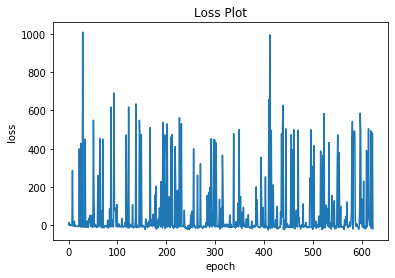

In [108]:
plt.title("Loss Plot")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(len(loss_plot)),loss_plot)
plt.savefig("Loss_U{}B{}Nt{}_{}.png".format(U,beta,Nt,count))

# Running L2HMC after training

In [125]:
n_samples = 200
nTrajs = 1

# samples_ = torch.tensor(HMCNotebook[n_samples], dtype=torch.float32)
# samples_ = torch.tensor(HMC_samples_reduced[:n_samples],dtype=torch.float32)
samples_ = torch.normal(0.0,usqrt,size=(n_samples,x_dim))
print("Starting positions for L2HMC=",samples_.shape)
L2HMC_acceptance = []
final_samples = []
L2HMC_px = []
# final_samples.append(samples_.detach().numpy())
with torch.no_grad():
    for t in tqdm(range(nTrajs)):       
        Lxx,Lvv,prob_x,samples_,log_jac,directions = propose(samples_, n_samples, dynamics, do_mh_step=True)
        samples_ = samples_[0]  # to get correct shape
        L2HMC_px.append(prob_x.detach().numpy())
        L2HMC_acceptance.append(directions.detach().numpy())
        final_samples.append(samples_.detach().numpy())
        


Starting positions for L2HMC= torch.Size([200, 64])


  0%|          | 0/1 [00:00<?, ?it/s]

In [126]:
L2HMC_samples = np.array(final_samples)
L2HMC_px = np.array(L2HMC_px).flatten()
L2HMC_acceptance = np.array(L2HMC_acceptance).flatten()
L2HMC_samples_reduced = L2HMC_samples.reshape(200,x_dim)

print("L2HMC samples mean px=",np.mean(L2HMC_px))
print("L2HMC_samples shape =",L2HMC_samples.shape)
print("L2HMC acceptance prob=",sum(L2HMC_acceptance)/len(L2HMC_acceptance))
print("L2HMC_samples reshape =",L2HMC_samples_reduced.shape)

L2HMC samples mean px= 0.3023233
L2HMC_samples shape = (1, 200, 64)
L2HMC acceptance prob= 0.3
L2HMC_samples reshape = (200, 64)


In [99]:
L2HMC_samples_reduced

array([[-0.3317126 ,  0.31573236,  0.23442324, ...,  0.1014179 ,
        -0.66014713,  0.16417435],
       [ 0.04957017, -0.6813915 ,  0.4259388 , ...,  0.5363573 ,
         0.09028851, -0.09633   ],
       [-0.4979974 , -0.9675326 , -0.93292665, ...,  0.6626811 ,
         2.0525823 ,  1.0735915 ],
       ...,
       [-0.2525708 ,  0.4058452 , -1.8922164 , ..., -0.2764022 ,
         1.1209738 ,  1.6980978 ],
       [ 1.1282675 ,  0.80402523, -0.876227  , ...,  0.40752944,
         0.24293385,  1.1249809 ],
       [ 0.24535523, -0.25644886, -0.28440717, ...,  0.7551417 ,
         1.0618546 ,  0.6348239 ]], dtype=float32)

In [113]:
phisq =np.square(L2HMC_samples_reduced)
print("phi sqaured shape=",phisq.shape)
phisq_mean = np.mean(phisq,axis=1)

phi sqaured shape= (10000, 64)


In [73]:
# trained parameters of the network
for name,param in dynamics.named_parameters():
    print(name,param)

alpha Parameter containing:
tensor(-4.6052)
XNet.scale_1 Parameter containing:
tensor([[-0.0716, -0.0961, -0.0729, -0.0934, -0.0894, -0.0420, -0.0646, -0.0983,
         -0.0431, -0.0823, -0.0701, -0.0974, -0.0641, -0.0976, -0.1170, -0.0389,
         -0.0651, -0.0725, -0.1082, -0.1090, -0.1025, -0.0596, -0.0577, -0.1213,
         -0.0786, -0.0708, -0.0599, -0.0645, -0.0881, -0.1049, -0.0635, -0.0976,
         -0.0820, -0.0980, -0.0731, -0.0940, -0.0822, -0.0525, -0.1166, -0.0981,
         -0.0541, -0.0834, -0.0921, -0.0959, -0.0835, -0.0741, -0.0679, -0.1008,
         -0.0528, -0.0805, -0.1132, -0.0744, -0.0487, -0.0696, -0.0855, -0.0984,
         -0.0758, -0.0381, -0.0536, -0.1058, -0.0814, -0.0756, -0.0433, -0.0446]],
       requires_grad=True)
XNet.scale_3 Parameter containing:
tensor([[ 0.1829,  0.2179,  0.2101,  0.1905,  0.1826,  0.2013,  0.1587,  0.1924,
          0.1826,  0.1511,  0.1062,  0.1629,  0.2036,  0.1638,  0.1821,  0.1864,
          0.1876,  0.2315,  0.1208,  0.1911,  0

# saving the config details

In [109]:
trained_AcceptanceMean = mean_px
trained_loss = loss_plot[-1]
HMC_AcceptanceSampleProb =sum(HMC_accepted)/nTrajs
HMC_Samples = HMC_samples.shape
HMC_Meanpx = np.mean(HMC_prob)
L2HMC_AcceptanceSampleProb = sum(L2HMC_acceptance)/nTrajs
L2HMC_Meanpx = np.mean(L2HMC_px)
L2HMC_Samples = L2HMC_samples.shape
lines = [f"U = {U}, beta = {beta}, Nt = {Nt}, Nx = {Nx}, dim = {x_dim}",f"Nmd = {Nmd}, eps = {final_eps}, scale = {scale}, epoch = {epochs}",
         f"training_Samples = {training_samples}",f"trained_AcceptanceMean = {trained_AcceptanceMean}",f"trained_loss = {trained_loss}",
         f"HMC_Samples = {HMC_Samples}",f"HMC_Meanpx = {HMC_Meanpx}",f"HMC_AcceptanceSampleProb = {HMC_AcceptanceSampleProb}",f"L2HMC_AcceptanceSampleProb = {L2HMC_AcceptanceSampleProb}",
         f"L2HMC_Meanpx={L2HMC_Meanpx}",f"L2HMC_Samples = {L2HMC_Samples}"]

with open(f'ConfigDetailsU{U}B{beta}Nt{Nt}_{count}.txt', 'w') as f:
    f.write('\n'.join(lines))

np.save("L2HMCU{}B{}Nt{}_{}.npy".format(U,beta,Nt,count),L2HMC_samples_reduced)
np.save(f"phisqU{U}B{beta}Nt{Nt}_{count}.npy",phisq)
np.save(f"HMCU{U}B{beta}Nt{Nt}_{count}.npy",HMC_samples_reduced)

# ACL spectrum 

In [ ]:
#auto correlation spectrum

# def acl_spectrum(X, scale):
#     n = X.shape[0]
#     return np.array([autocovariance_2(X / scale, tau=t) for t in range(n - 1)])

# def autocovariance_2(X, tau=0):
#     dT, dN, dX = np.shape(X)
#     s = 0.
#     for t in range(dT - tau):
#         x1 = X[t, :, :]
#         x2 = X[t+tau, :, :]
#         s += np.sum(x1 * x2) / dN


#     return s / (dT - tau)



In [ ]:
# scale = 32
# L2HMC_auto = acl_spectrum(L2HMC_samples, scale=scale)

In [ ]:
# points = 50
# xaxis = 1 * np.arange(points)
# gradient = Nmd*np.arange(points)
# plt.title("Auto correlation for L2HMC sampled $\phi$")
# # plt.xlabel("lags")
# plt.xlabel("gradient computation")
# plt.ylabel("Auto-correlation")
# plt.grid(True)
# # plt.plot(xaxis, L2HMC_auto[:points], label=f"{points}")
# plt.plot(gradient, L2HMC_auto[:points], label=f"{points}")
# plt.legend()
# # plt.savefig("L2HMCAC_U{}B{}Nt{}_{}.png".format(U,beta,Nt,count))

In [ ]:
# scale = 32
# L2HMC_auto_phisq = acl_spectrum(phisq_mean, scale=scale)

In [ ]:
# points = 1000
# xaxis = 1 * np.arange(points)
# gradient = 5*np.arange(points)
# plt.title("Auto correlation for L2HMC sampled $\phi^2$")
# plt.xlabel("lags")
# # plt.xlabel("gradient computation")
# plt.ylabel("Auto-correlation")
# plt.grid(True)
# plt.plot(xaxis, L2HMC_auto_phisq[:points],'.', label=f"{points}")
# # plt.plot(gradient, L2HMC_auto_phisq[:points], label=f"{points}")
# plt.legend()
# # plt.savefig("L2HMCACphisq_U{}B{}Nt{}_{}.png".format(U,beta,Nt,count))

# ACL spectrum using mathplotlib 

In [ ]:
# plt.acorr(L2HMC_samples/32., usevlines = True, normed = True, maxlags = 100, lw = 2)
# plt.title(" Autocorrelation of $\phi$")
# plt.xlabel("lags")
# plt.ylabel("Auto-Correlation ")
# plt.grid(True)
# plt.acorr(phisq_mean/32, usevlines = True, normed = True, maxlags = 100, lw = 2)
# plt.title(" Autocorrelation of $\phi^2$")
# plt.xlabel("lags")
# plt.ylabel("Auto-Correlation ")
# plt.grid(True)

# ACL spectrum using statsmodel

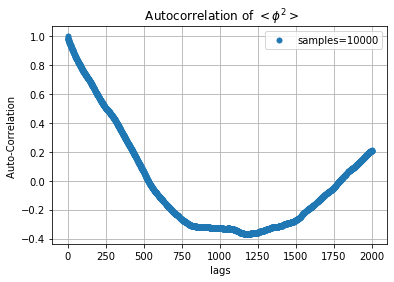

In [122]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
lags = 2000
therm = 100

# plot_acf(L2HMC_samples.flatten(),lags=1000,use_vlines=False,alpha=None)
# plt.title(" Autocorrelation of $\phi$")
# plt.xlabel("lags")
# plt.ylabel("Auto-Correlation ")
# plt.savefig("L2HMCAC_U{}B{}Nt{}_{}.png".format(U,beta,Nt,count))

ac = acf(phisq_mean[therm:],nlags=lags,alpha=None)
plot_acf(phisq_mean[therm:],lags=lags,use_vlines=False,alpha=None,label=f"samples={len(phisq_mean)}")
plt.grid()
plt.title(" Autocorrelation of $<\phi^2>$")
plt.xlabel("lags")
plt.ylabel("Auto-Correlation ")
plt.legend()
# plt.savefig(f"phisqMeanAuto_U{U}B{beta}Nt{Nt}_{count}.png")

In [117]:
ac[-1]

-0.0021543603756693764

# Exact coorelators

In [ ]:
# exactData1 = open("C:/Users/chels/Desktop/thesis_code/l2hmcPytorch/exact2sites/exact.two_sites.exp.nt128.beta4_0.U2_0.mu0_0.txt").read().split('\n')
# exT1 = np.array(exactData[0].split(','),dtype=float)
# exBonding1 =  np.array(exactData[1].split(','),dtype=float)
# exAntiBonding1 = np.array(exactData[2].split(','),dtype=float)


In [11]:
#Exact co-relators data 
exactData = open("C:\\Users\\chels\\Desktop\\thesis_code\\NNgHMC\\exactFiles\\U4B6.dat").readlines()
exT = []
exBonding = []
exAntiBonding = []
exAA = []
exAB = []
exBA = []
exBB = []
for i in range(len(exactData)):
    split = exactData[i].split()
    exT.append(float(split[0]))   # tau
    exAntiBonding.append(float(split[1]))  # anti-bonding
    exBonding.append(float(split[2]))      # bonding
    exAA.append(float(split[3]))  # cAA
    exAB.append(float(split[4]))  # cAB
    exBA.append(float(split[5]))  # cBA
    exBB.append(float(split[6]))  # cBB

# Correlators Calculation with Binning and bootstrap error

In [12]:
#Calculating co-relators 

def correlators(sample):

    corrUp_b = [ [] for t in range(Nt)] # <===== each correlator has Nt elements
    corrUp_ab = [ [] for t in range(Nt)]
    Cxx = [ [] for t in range(Nt)]
    Cxy = [ [] for t in range(Nt)]
    Cyx = [ [] for t in range(Nt)]
    Cyy = [ [] for t in range(Nt)]

    nTherm = 200

    ### calculate the bonding/anti-bonding correlator
    for i in range(nTherm,nTrajs):
        # arrow up correlator
        phi = sample[i]
        Mphi(phi,expk,Nt)
        invMUp = np.linalg.inv(M)

        #  construct the correlators
        # bonding correlator is .5*(Cxx+Cxy+Cyx+Cyy)
        # antibonding is .5*(Cxx-Cxy-Cyx+Cyy)
        for t in range(Nt):
            corrUp_b[t].append(np.real(.5*(invMUp[t*Nx+0][0*Nx+0]+invMUp[t*Nx+0][0*Nx+1]+
                                   invMUp[t*Nx+1][0*Nx+0]+invMUp[t*Nx+1][0*Nx+1])))
            corrUp_ab[t].append(np.real(.5*(invMUp[t*Nx+0][0*Nx+0]-invMUp[t*Nx+0][0*Nx+1]-
                                   invMUp[t*Nx+1][0*Nx+0]+invMUp[t*Nx+1][0*Nx+1])))
            Cxx[t].append(np.real(invMUp[t*Nx+0][0*Nx+0]))
            Cxy[t].append(np.real(invMUp[t*Nx+0][0*Nx+1]))
            Cyx[t].append(np.real(invMUp[t*Nx+1][0*Nx+0]))
            Cyy[t].append(np.real(invMUp[t*Nx+1][0*Nx+1]))

    # arrays that store the averages
    corrBond = []
    corrAntiBond = []

    # naming conventions.  Here 'A' = 'x' and 'B' = 'y'
    cAA = []
    cAB = []
    cBA = []
    cBB = []

    # now I calculate the averages for each timeslice
    for t in range(Nt):
        corrBond.append(np.mean(corrUp_b[t]))
        corrAntiBond.append(np.mean(corrUp_ab[t]))
        cAA.append(np.mean(Cxx[t]))
        cAB.append(np.mean(Cxy[t]))
        cBA.append(np.mean(Cyx[t]))
        cBB.append(np.mean(Cyy[t]))

    tau = np.linspace(0,beta-beta/Nt,Nt) # <===== correct distancing for tau
    return corrBond,corrAntiBond,cAA,cAB,cBA,cBB,tau,corrUp_b,corrUp_ab,Cxx,Cxy,Cyx,Cyy



In [13]:
#Binning and Bootstraping
def binAndBoot(corr,nBN,nBS,check):
    # corr is the array of of correlators 
    # nBN is the number or elements to bin
    # nBS is the number of bootstrap samples
    if check == 1:
        # making the correlators in correct form [samples]x[Nt]
        correlators = []
        for i in range(len(corr[0])): # range(samples)
            correlators.append([corr[t][i] for t in range(len(corr))]) #range(Nt)
    else:
        correlators = corr
        
    corrBN = [] #shape [(samples)/nBN x Nt]
    for i in range(int(len(correlators)/nBN)): #range(samples/nBN)
        corrBN.append(np.mean(correlators[i*nBN:(i+1)*nBN],axis=0))
        
    n = len(corrBN)  # length of ensemble (samples/nBN)
    bsMeans = []
    
    # here are my bootstrap indices
    bsSamples = [ np.random.randint(n,size=n) for bs in range(nBS)]  #shape [nBS x (samples/nBN) ]
    for sample in bsSamples: #shape [(samples/nBN) ]
        bsMeans.append(np.mean([corrBN[index] for index in sample],axis=0))   # mean along rows( [(samples/nBN) x Nt]) 
    # bsMeans.append([1 x Nt]), shape [nBS x 16]
    # returns array of shape[1 x Nt]
    return np.std(bsMeans,axis=0) 

In [91]:
M = np.identity(x_dim) + 0j
a_corrBond,a_corrAntiBond,a_cAA,a_cAB,a_cBA,a_cBB,a_tau,a_corrUp_b,a_corrUp_ab,a_Cxx,a_Cxy,a_Cyx,a_Cyy = correlators(HMC_samples_reduced)
# b_corrBond,b_corrAntiBond,b_cAA,b_cAB,b_cBA,b_cBB,b_tau,b_corrUp_b,b_corrUp_ab,b_Cxx,b_Cxy,b_Cyx,b_Cyy = correlators(HMCNotebook[:nTrajs])
nbins = 200  #number of bins
nbs = 400   # number of bootstrap samples

In [103]:
nbins = 200  #number of bins
nbs = 400   # number of bootstrap samples
corrBond,corrAntiBond,cAA,cAB,cBA,cBB,tau,corrUp_b,corrUp_ab,Cxx,Cxy,Cyx,Cyy = correlators(L2HMC_samples_reduced)

In [98]:
print(corrBond,corrAntiBond)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


# plotting correlators

Text(0.5, 0.98, '2 site Hexagonal Lattice\nU=4.0, beta=6.0, Nt=32, samples=10000')

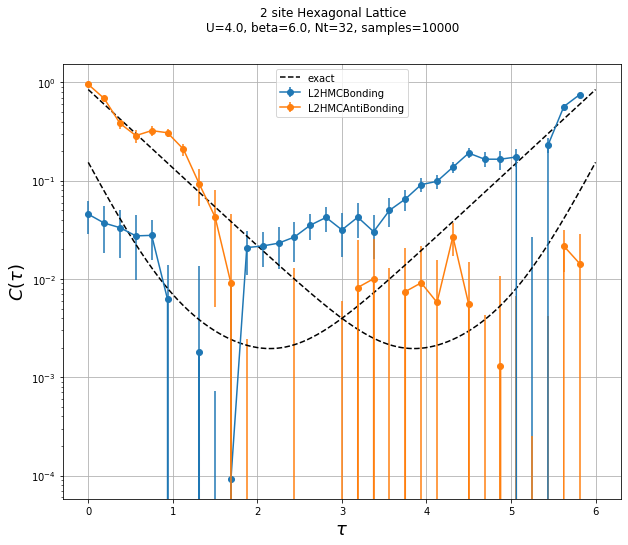

In [104]:
plt.figure(figsize=(10,8))
plt.errorbar(tau,corrBond,yerr=binAndBoot(corrUp_b,nbins,nbs,1),marker='o',label='L2HMCBonding')
plt.errorbar(tau,corrAntiBond,yerr=binAndBoot(corrUp_ab,nbins,nbs,1),marker='o',label='L2HMCAntiBonding')
plt.plot(exT,exBonding,'k--',label='exact')
plt.plot(exT,exAntiBonding,'k--')
plt.grid()
plt.ylabel(r'$C(\tau)$',fontsize=18)
plt.xlabel(r'$\tau$',fontsize=18)
plt.yscale('log')
plt.legend(loc='best')
plt.suptitle('2 site Hexagonal Lattice\nU={}, beta={}, Nt={}, samples={}'.format(U,beta,Nt,nTrajs,fontsize=20))
# plt.savefig("2siteL2HMCBonding_U{}B{}Nt{}_{}.png".format(U,beta,Nt,count))

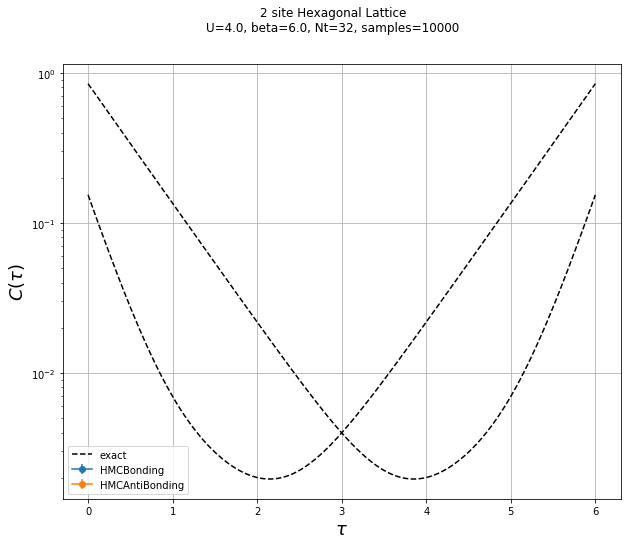

In [110]:
plt.figure(figsize=(10,8))
plt.errorbar(a_tau,a_corrBond,yerr=binAndBoot(a_corrUp_b,nbins,nbs,1),marker='o',label='HMCBonding')
plt.errorbar(a_tau,a_corrAntiBond,yerr=binAndBoot(a_corrUp_ab,nbins,nbs,1),marker='o',label='HMCAntiBonding')
plt.plot(exT,exBonding,'k--',label='exact')
plt.plot(exT,exAntiBonding,'k--')
plt.grid()
plt.ylabel(r'$C(\tau)$',fontsize=18)
plt.xlabel(r'$\tau$',fontsize=18)
plt.yscale('log')
plt.legend(loc='best')
plt.suptitle('2 site Hexagonal Lattice\nU={}, beta={}, Nt={}, samples={}'.format(U,beta,Nt,nTrajs,fontsize=20))
plt.savefig("2siteL2HMCBonding_U{}B{}Nt{}_{}.png".format(U,beta,Nt,count))

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,15))

axx = ax[0]
axx.errorbar(a_tau,a_corrBond,yerr=binAndBoot(a_corrUp_b,nbins,nbs,1),marker='o',label='HMCBonding')
axx.errorbar(a_tau,a_corrAntiBond,yerr=binAndBoot(a_corrUp_ab,nbins,nbs,1),marker='o',label='HMCAntiBonding')
axx.plot(exT,exBonding,'k--',label='exact')
axx.plot(exT,exAntiBonding,'k--')
axx.grid(True)
axx.set_xlabel(r'$t$',fontsize=18)
axx.set_ylabel(r'$C_{\pm}$',fontsize=18)
axx.set_yscale('log')
axx.legend(loc='best')

# axx = ax[1]
# axx.errorbar(tau,corrBond,yerr=binAndBoot(corrUp_b,nbins,nbs,1),marker='o',label='L2HMCBonding')
# axx.errorbar(tau,corrAntiBond,yerr=binAndBoot(corrUp_ab,nbins,nbs,1),marker='o',label='L2HMCAntiBonding')
# axx.plot(exT,exBonding,'k--',label='exact')
# axx.plot(exT,exAntiBonding,'k--')
# axx.grid()
# axx.set_xlabel(r'$t$',fontsize=18)
# axx.set_yscale('log')
# axx.legend(loc='best')

# axx = ax[2]
# axx.errorbar(a_tau,a_corrBond,yerr=binAndBoot(a_corrUp_b,nbins,nbs,1),marker='o',label='HMCBonding')
# axx.errorbar(tau,corrAntiBond,yerr=binAndBoot(corrUp_ab,nbins,nbs,1),marker='o',label='L2HMCAntiBonding')
# axx.errorbar(a_tau,a_corrAntiBond,yerr=binAndBoot(a_corrUp_ab,nbins,nbs,1),marker='o',label='HMCAntiBonding')
# axx.errorbar(tau,corrBond,yerr=binAndBoot(corrUp_b,nbins,nbs,1),marker='o',label='L2HMCBonding')
# axx.plot(exT,exBonding,'k--',label='exact')
# axx.plot(exT,exAntiBonding,'k--')
# axx.grid()
# axx.set_xlabel(r'$t$',fontsize=18)
# axx.set_yscale('log')
# axx.legend(loc='best')

# # axx = ax[1][1]
# # # axx.errorbar(a_tau,a_corrBond,yerr=binAndBoot(a_corrUp_b,nbins,nbs,1),marker='o',label='HMCBonding')
# # # axx.errorbar(a_tau,a_corrAntiBond,yerr=binAndBoot(a_corrUp_ab,nbins,nbs,1),marker='o',label='HMCAntiBonding')
# # # axx.errorbar(b_tau,b_corrBond,yerr=binAndBoot(b_corrUp_b,nbins,nbs,1),marker='o',label='actual_HMCBonding')
# # # axx.errorbar(b_tau,b_corrAntiBond,yerr=binAndBoot(b_corrUp_ab,nbins,nbs,1),marker='o',label='actual_HMCAntiBonding')
# # # axx.plot(exT,exBonding,'k--',label='exact')
# # # axx.plot(exT,exAntiBonding,'k--')
# # axx.set_xlabel(r'$t$',fontsize=18)
# # axx.set_yscale('log')
# # axx.grid()
# # axx.legend(loc='best')

plt.suptitle('U={}, beta={}, Nt={} samples={} \n HMC:using L2HMC w/o NN'.format(U,beta,Nt,nTrajs,fontsize=20))

# #axx.plot(exT[::50],exBonding[::50],'ro',label='exactBonding')
# #axx.plot(exT[::50],exAntiBonding[::50],'bo',label='exactAntibonding')
# #axx.plot(np.array(a_corrBond) - np.array(corrBond),'ro',label= r'$diff_Bonding$')
# #axx.plot(np.array(a_corrAntiBond) - np.array(corrAntiBond),'bo', label = '$diff_Antibonding$')

# plt.savefig("L2HMCBonding_U{}B{}Nt{}_{}.png".format(U,beta,Nt,count))

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(15,10),sharex=True)

aax = ax[0][0]
aax.plot(exT,exAA,'k--',label='exact')
aax.errorbar(tau,cAA,yerr=binAndBoot(Cxx,nbins,nbs,1),marker='o',label='L2HMC')
aax.errorbar(a_tau,a_cAA,yerr=binAndBoot(a_Cxx,nbins,nbs,1),marker='o',label='HMC')
# aax.errorbar(b_tau,b_cAA,yerr=binAndBoot(b_Cxx,nbins,nbs,1),marker='o',label='actual_HMC')
aax.set_yscale('log')
aax.legend(loc='best')
aax.set_ylabel(r'$C_{AA}(\tau)$')
aax.grid()

aax = ax[0][1]
aax.plot(exT,exAB,'k--',label='exact')
aax.errorbar(tau,cAB,yerr=binAndBoot(Cxy,nbins,nbs,1),marker='o',label='L2HMC')
aax.errorbar(a_tau,a_cAB,yerr=binAndBoot(a_Cxy,nbins,nbs,1),marker='o',label='HMC')
# aax.errorbar(b_tau,b_cAB,yerr=binAndBoot(b_Cxy,nbins,nbs,1),marker='o',label='actual_HMC')
aax.set_ylabel(r'$C_{AB}(\tau)$')
aax.legend(loc='best')
aax.grid()

aax = ax[1][0]
aax.plot(exT,exBA,'k--',label='exact')
aax.errorbar(tau,cBA,yerr=binAndBoot(Cyx,nbins,nbs,1),marker='o',label='L2HMC')
aax.errorbar(a_tau,a_cBA,yerr=binAndBoot(a_Cyx,nbins,nbs,1),marker='o',label='HMC')
# aax.errorbar(b_tau,b_cBA,yerr=binAndBoot(b_Cyx,nbins,nbs,1),marker='o',label='actual_HMC')
aax.grid()
aax.set_xlabel(r'$\tau$')
aax.set_ylabel(r'$C_{BA}(\tau)$')
aax.legend(loc='best')

aax = ax[1][1]
aax.plot(exT,exBB,'k--',label='exact')
aax.errorbar(tau,cBB,yerr=binAndBoot(Cyy,nbins,nbs,1),marker='o',label='L2HMC')
aax.errorbar(a_tau,a_cBB,yerr=binAndBoot(a_Cyy,nbins,nbs,1),marker='o',label='HMC')
# aax.errorbar(b_tau,b_cBB,yerr=binAndBoot(b_Cyy,nbins,nbs,1),marker='o',label='actual_HMC')
aax.grid()
aax.set_yscale('log')
aax.set_xlabel(r'$\tau$')
aax.set_ylabel(r'$C_{BB}(\tau)$')
aax.legend(loc='best')

plt.suptitle('U={}, beta={}, Nt={}, samples={} \n HMC:using L2HMC w/o NN'.format(U,beta,Nt,nTrajs,fontsize=20))
# plt.savefig("L2HMCCorAll_U{}B{}Nt{}_{}.png".format(U,beta,Nt,count))

Text(0.5, 0.98, 'U=4.0, beta=6.0, Nt=32, samples=1')

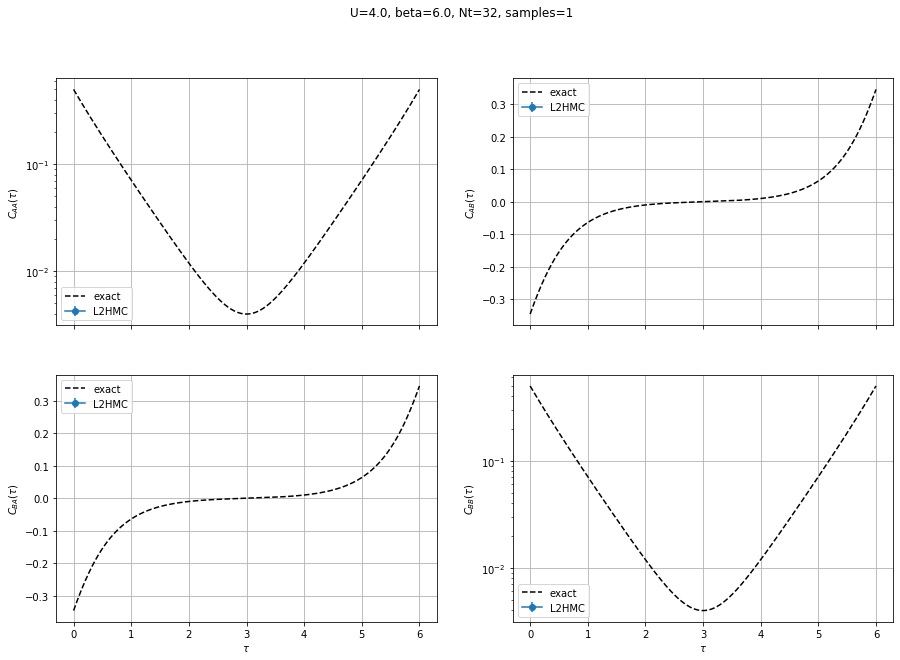

In [100]:
fig,ax = plt.subplots(2,2,figsize=(15,10),sharex=True)

aax = ax[0][0]
aax.plot(exT,exAA,'k--',label='exact')
aax.errorbar(tau,cAA,yerr=binAndBoot(Cxx,nbins,nbs,1),marker='o',label='L2HMC')
aax.set_yscale('log')
aax.legend(loc='best')
aax.set_ylabel(r'$C_{AA}(\tau)$')
aax.grid()

aax = ax[0][1]
aax.plot(exT,exAB,'k--',label='exact')
aax.errorbar(tau,cAB,yerr=binAndBoot(Cxy,nbins,nbs,1),marker='o',label='L2HMC')
aax.set_ylabel(r'$C_{AB}(\tau)$')
aax.legend(loc='best')
aax.grid()

aax = ax[1][0]
aax.plot(exT,exBA,'k--',label='exact')
aax.errorbar(tau,cBA,yerr=binAndBoot(Cyx,nbins,nbs,1),marker='o',label='L2HMC')
aax.grid()
aax.set_xlabel(r'$\tau$')
aax.set_ylabel(r'$C_{BA}(\tau)$')
aax.legend(loc='best')

aax = ax[1][1]
aax.plot(exT,exBB,'k--',label='exact')
aax.errorbar(tau,cBB,yerr=binAndBoot(Cyy,nbins,nbs,1),marker='o',label='L2HMC')
aax.grid()
aax.set_yscale('log')
aax.set_xlabel(r'$\tau$')
aax.set_ylabel(r'$C_{BB}(\tau)$')
aax.legend(loc='best')

plt.suptitle('U={}, beta={}, Nt={}, samples={}'.format(U,beta,Nt,nTrajs,fontsize=20))
# plt.savefig("L2HMCCor_U{}B{}Nt{}_{}.png".format(U,beta,Nt,count))